# Data exploration
Understanding the structure of training data and publications provided by [Coleridge Kaggle](https://www.kaggle.com/c/coleridgeinitiative-show-us-the-data/data) competition (section titles, indicator terms). Adapted to also explore manually explore training data (sentences) for feature selection. 

Questions:
1. Where in publications do data citations occur? (Introduction, Abstract, Discussion...)
2. Are more data citations formal or informal? (mostly informal; no reference section given, evidence that title variants used)
3. What indicator terms accompany a data citation? ("com", "inc", "dataset", "obtained from", "database")
4. What named entities are mentioned in data citations? (ORG, CARDINAL, DATE...)
5. What distinctive terms are found in data titles/labels/citations? (TF-IDF)

Takeaways:
- Section could be used as a weight but it's not very indicative
- Flagging indicator terms might be a useful approach to find candidate phrases
- NER merits its own pipeline (probably in spaCy)
- TF-IDF of IDF may be used to weight terms

Note: NER should be done prior to preprocessing as rules like capitalization and punctuation provide clues. 

To do: 
- [ ] What are the research fields of publications and datasets? (TBD: look up pub abstracts w/crossref API, apply to datasets)

In [4]:
import glob
import re
from collections import defaultdict, Counter

import pandas as pd

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags

import spacy
import en_core_web_sm
from spacy.displacy.render import EntityRenderer
from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
nlp = en_core_web_sm.load()

In [6]:
def clean_text(txt):
    """
    Convert to lowercase, remove special characters, and punctuation.
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

In [2]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [5]:
path = '../data/'

## Load data

Datasets referenced in publications
- Coleridge training data

In [6]:
df_train = pd.read_csv(path+'train.csv',low_memory=False)
df_train.sample(n=5)

,Id,pub_title,dataset_title,dataset_label,cleaned_label
541,c5d27545-4a25-4adc-8dcf-7a2f8421fc77,Effects of age and aerobic capacity on arteria...,Baltimore Longitudinal Study of Aging (BLSA),Baltimore Longitudinal Study of Aging (BLSA),baltimore longitudinal study of aging blsa
5012,75c5eff6-27c1-4fd3-9d35-68e48799e6cd,A Cochrane review on brain [18F]FDG PET in dem...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,adni
10679,be9a48e7-0167-46c9-b482-74832f01e39a,Regression models on Riemannian symmetric spaces,Alzheimer's Disease Neuroimaging Initiative (A...,Alzheimer's Disease Neuroimaging Initiative (A...,alzheimer s disease neuroimaging initiative adni
14990,fea1537a-160c-437e-9849-1fda49f0d66e,Implications for practice and research from D...,Survey of Earned Doctorates,Survey of Earned Doctorates,survey of earned doctorates
10188,156abbf4-d75f-4457-949d-a60da16293f9,Quantitative magnetic resonance imaging traits...,Alzheimer's Disease Neuroimaging Initiative (A...,Alzheimer's Disease Neuroimaging Initiative (A...,alzheimer s disease neuroimaging initiative adni


How similar are `dataset_label` and `dataset_title`? This will help us understand if the goal of the competition is to predict `dataset_label`

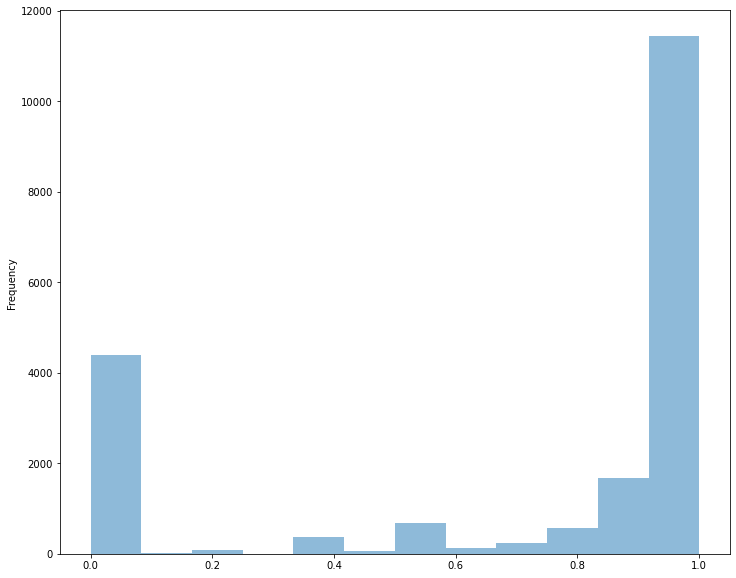

In [7]:
data_jaccard = []
for index, row in df_train.iterrows():
    data_jaccard.append(jaccard(row['dataset_title'], row['dataset_label']))
    
df_train['data_jaccard'] = data_jaccard
df_train['data_jaccard'].plot.hist(bins=12, alpha=0.5, figsize=(12,10))

Wow! Most of the training data labels and titles have a similarity score of 0.8 or higher. This means a solution where we just search for massive list of dataset titles would perform very well. Let's see instances with imperfect overlap. These may be solved by changing the order of the terms and/or partial matching

In [8]:
low_match = df_train[df_train['data_jaccard'] < .2] 
low_match

,Id,pub_title,dataset_title,dataset_label,cleaned_label,data_jaccard
311,f4a8e3b6-17b7-41d6-9b29-d347a2459317,The Effect of the Surface Wind Field Represent...,"Sea, Lake, and Overland Surges from Hurricanes",SLOSH model,slosh model,0.000000
312,66a010dd-7dd4-4f64-a45c-7f412f786762,Risk assessment of hurricane storm surge for N...,"Sea, Lake, and Overland Surges from Hurricanes",SLOSH model,slosh model,0.000000
313,78acf162-36f4-47bb-8b8f-645d3195361f,Visualization for Hurricane Storm Surge Risk A...,"Sea, Lake, and Overland Surges from Hurricanes",SLOSH model,slosh model,0.000000
314,2e9afd1e-3538-4615-92a5-f18a550378f8,Predicting the Storm Surge Threat of Hurricane...,"Sea, Lake, and Overland Surges from Hurricanes",SLOSH model,slosh model,0.000000
315,2c2e7822-a9e5-42aa-9307-2456e9d18ad8,"Internet-based Modeling, Mapping, and Analysis...","Sea, Lake, and Overland Surges from Hurricanes",SLOSH model,slosh model,0.000000
...,...,...,...,...,...,...
19610,7145e494-588c-48b4-9a6f-77c0bfdb082a,Novel Dynamic Structures of 2019-nCoV with Non...,SARS-CoV-2 genome sequence,genome sequences of 2019-nCoV,genome sequences of 2019 ncov,0.166667
19611,bb5c15aa-ad9d-4441-a5f3-39e85382637c,Prevalence and impact of cardiovascular metabo...,SARS-CoV-2 genome sequence,genome sequences of 2019-nCoV,genome sequences of 2019 ncov,0.166667
19612,43baf587-ff28-4f1f-b92f-6e61aad8b682,Emerging novel coronavirus (2019-nCoV)—current...,SARS-CoV-2 genome sequence,genome sequences of 2019-nCoV,genome sequences of 2019 ncov,0.166667
19613,d90a010d-8dba-4ffa-a2f1-473a45ddb8c7,Identification of potential inhibitors of SARS...,SARS-CoV-2 genome sequence,genome sequences of 2019-nCoV,genome sequences of 2019 ncov,0.166667


Publication sections
- Coleridge data

In [6]:
df_pubs = pd.read_csv(path+'test_publications.csv',low_memory=False)
df_pubs['clean_section'] = df_pubs['section_title'].apply(clean_text)
df_pubs.sample(n=5)

,Id,section_title,text,clean_text,clean_section
131619,79ad4836-8353-49d4-9df3-5258d234f00f,"Survival, Serious Illness, and Hospitalization",Because of the disease's rapid increasing case...,because of the disease s rapid increasing case...,survival serious illness and hospitalization
137350,4e63a762-190f-413c-b5c4-5ec729cb6e67,STUDENT LEARNING AND SCHOOL SECTOR: VARIABLE E...,Data sets analyzed in prior studies of school ...,data sets analyzed in prior studies of school ...,student learning and school sector variable ef...
53433,40751544-944a-4baa-946f-967a0d693856,INTRODUCTION,It has become very urgent whether it was for t...,it has become very urgent whether it was for t...,introduction
215560,a3862f1c-6331-45d9-b764-309b770d584e,The Complex Relationship Between English Profi...,"Finally, it is important to note that, althoug...",finally it is important to note that although ...,the complex relationship between english profi...
29039,e0565e86-97e1-4b84-9c92-e3c33d5a2173,Acknowledgments,This work was supported by the EU FP7/2007-201...,this work was supported by the eu fp7 2007 201...,acknowledgments


Publication abstracts (for lookup in an external service to gather more metadata)

In [9]:
df_pubs['text'] = df_pubs['text'].astype(str)
abstracts = df_pubs[df_pubs['text'].str.contains("Abstract")]
abstracts = abstracts.drop(columns=['section_title', 
                      'clean_text', 
                      'clean_section'])
abstracts

,Id,text
46,a33580fc-3e2b-4b6c-80f3-04f8613f48c0,Abstract: Quantitative measurement of b-amyloi...
92,a7db5716-d532-409a-abc7-79845726b3ba,Abstract This paper discusses the differences ...
230,2c92ec97-80b4-4c5a-82eb-ffa2a32941b2,Abstract: Agricultural Centers are a coalition...
316,ebc5c768-6f07-4cc8-97f9-c42d11f0a2ac,Abstract The United States is the largest prod...
781,e2c9b03b-5222-4bfe-bc85-4ff16ba1996e,Abstract. Hippocampus volumetry based on magne...
...,...,...
258278,c4ece408-ffbb-4c75-855c-1af2f013c395,Abstract This study examined the longitudinal ...
258336,d5fefd68-12c9-41e8-aac1-d2495dd62da1,Abstract -As animal agriculture has evolved to...
258396,3ae9d767-e18d-4c4c-bb52-55321031b65a,Abstract This study examined differences betwe...
258583,722c17b4-f696-446f-8bef-49413df06cb3,"Kanae, S. (2017). Compound simulation of fluvi..."


Publication full text

In [26]:
grouped_pubs = df_pubs.groupby(['Id'], as_index = False).agg({'text': ' '.join})
grouped_pubs

,Id,text
0,0007f880-0a9b-492d-9a58-76eb0b0e0bd7,The aim of this study was to identify if acqui...
1,0008656f-0ba2-4632-8602-3017b44c2e90,"In this study, Finnish ninth graders' and thei..."
2,000e04d6-d6ef-442f-b070-4309493221ba,Through the U.S. Department of Agriculture's E...
3,000efc17-13d8-433d-8f62-a3932fe4f3b8,Risk factors and cognitive sequelae of brain a...
4,0010357a-6365-4e5f-b982-582e6d32c3ee,Potential Conflicts of Interest: The author ha...
...,...,...
14311,ffd19b3c-f941-45e5-9382-934b5041ec96,"Water-quality data for nitrate, fecalindicator..."
14312,ffd4d86a-0f26-44cc-baed-f0e209cc22af,Magnetic Resonance Imaging (MRI) is of fundame...
14313,ffe7f334-245a-4de7-b600-d7ff4e28bfca,The COVID-19 pandemic and the fear that it has...
14314,ffeb3568-7aed-4dbe-b177-cbd7f46f34af,"Mathematics, as no other school subject, evoke..."


Flag sections of publications with a data citation

In [24]:
df_full = df_train.merge(df_pubs, on='Id')
df_full['dataset_label'] = df_full['dataset_label'].astype(str)
df_full['text'] = df_full['text'].astype(str)
df_full['match'] = df_full.apply(lambda x: x.dataset_label in x.text, axis=1)
df_full['match'].value_counts()

False    350661
True      33496
Name: match, dtype: int64

## Describe data

Unique titles and labels of datasets (45) and publications (14,271) in training data

In [27]:
for col in df_train.columns:
    print(f"{col}: {len(df_train[col].unique())}")

Id: 14316
pub_title: 14271
dataset_title: 45
dataset_label: 130
cleaned_label: 130


In [28]:
dataset_titles_unique = df_train['dataset_title'].unique()

variants = []
for dataset_title in dataset_titles_unique:
    if len(df_train[df_train["dataset_title"] == dataset_title]["dataset_label"].unique()) > 1:
        variants.append(df_train[df_train["dataset_title"] == dataset_title]["dataset_label"].unique())

print("There are", f"{len(variants)}", "datasets with name variants across publications, e.g.,")
print(variants[0])

There are 31 datasets with name variants across publications, e.g.,
['NOAA tidal station' 'NOAA National Water Level Observation Network'
 'NOAA water level station' 'National Water Level Observation Network'
 'NOAA Tide Gauge' 'NOAA tide station']


In [30]:
print("There are", f"{df_train['dataset_title'].nunique()}", "unique datasets in the training data")

There are 45 unique datasets in the training data


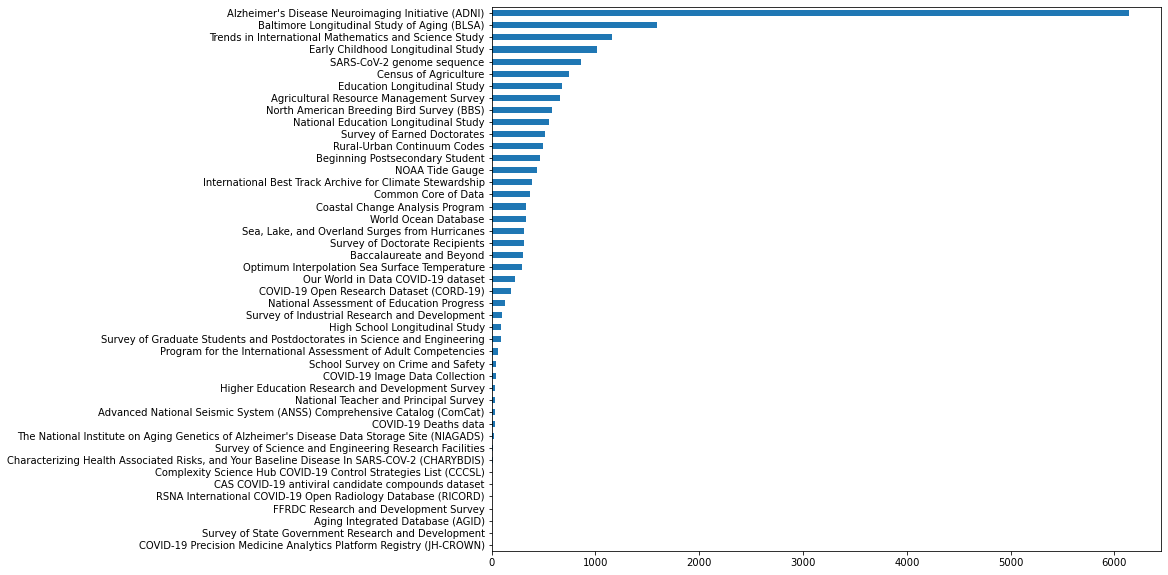

In [31]:
dataset_titles_counts = df_train['dataset_title'].value_counts().sort_values()
dataset_titles_counts.plot(kind='barh',figsize=(12,10))

In [29]:
multi_mentions = []

for Id in df_train['Id'].unique():
    num_unique_mentions = len(df_train[df_train['Id'] == Id]['dataset_title'].unique())
    if num_unique_mentions > 1:
        multi_mentions.append((Id, num_unique_mentions))

print("There are", f"{len(multi_mentions)}", "publications that mention more than one dataset, e.g.,")
print(multi_mentions[1:5])

There are 965 publications that mention more than one dataset, e.g.,
[('2f26f645-3dec-485d-b68d-f013c9e05e60', 2), ('c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29', 2), ('5c9a3bc9-41ba-4574-ad71-e25c1442c8af', 2), ('c754dec7-c5a3-4337-9892-c02158475064', 2)]


In [32]:
co_mentions = defaultdict(int)

for Id, num_mentions in multi_mentions:
    co_mentions[tuple(sorted(df_train[df_train['Id'] == Id]["dataset_title"].unique()))] += 1

print("There are", f"{len(co_mentions)}", "datasets that co-occur in publications, e.g.,")
print(("'Education Longitudinal Study', 'National Education Longitudinal Study'): 411", co_mentions["'Education Longitudinal Study', 'National Education Longitudinal Study')"]))

There are 113 datasets that co-occur in publications, e.g.,
("'Education Longitudinal Study', 'National Education Longitudinal Study'): 411", 0)


## Which **publication sections** have data citations?

For now, let's only keep sections of publications that have a data citation

In [33]:
df_full = df_full[df_full['match']==True]
df_full

,Id,pub_title,dataset_title,dataset_label,cleaned_label,section_title,text,clean_text,clean_section,match
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,What is this study about?,This study used data from the National Educati...,this study used data from the national educati...,what is this study about,True
9,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Degree attainment,Any college degree attainment The study author...,any college degree attainment the study author...,degree attainment,True
10,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Bachelor's degree attainment,The study author collected information on bach...,the study author collected information on bach...,bachelor s degree attainment,True
18,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,Education Longitudinal Study,Education Longitudinal Study,education longitudinal study,What is this study about?,This study used data from the National Educati...,this study used data from the national educati...,what is this study about,True
27,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,Education Longitudinal Study,Education Longitudinal Study,education longitudinal study,Degree attainment,Any college degree attainment The study author...,any college degree attainment the study author...,degree attainment,True
...,...,...,...,...,...,...,...,...,...,...
384105,f77eb51f-c3ac-420b-9586-cb187849c321,MCCS: a novel recognition pattern-based method...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,Introduction,"The outbreak of the coronavirus disease 2019 ,...",the outbreak of the coronavirus disease 2019 c...,introduction,True
384108,f77eb51f-c3ac-420b-9586-cb187849c321,MCCS: a novel recognition pattern-based method...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,Virtual screening by MCCS,Starting with the code base of the current sta...,starting with the code base of the current sta...,virtual screening by mccs,True
384114,f77eb51f-c3ac-420b-9586-cb187849c321,MCCS: a novel recognition pattern-based method...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,Repurposing CAS COVID-19 antiviral candidate c...,MCCS was also used to predict the potential ca...,mccs was also used to predict the potential ca...,repurposing cas covid 19 antiviral candidate c...,True
384125,fd23e7e0-a5d2-4f98-992d-9209c85153bb,A ligand-based computational drug repurposing ...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,NaN,deployment of approximative mathematical model...,deployment of approximative mathematical model...,nan,True


Here are the most common terms that show up in research publication sections. Since sections are called different things, we need to normalize and create a new column of normalized section names (ex. 'method', 'methods', 'methodology' all become 'method')

In [34]:
Counter(" ".join(df_full['clean_section']).split()).most_common(100)

[('and', 5195),
 ('introduction', 3792),
 ('data', 3588),
 ('of', 3193),
 ('abstract', 2129),
 ('the', 2078),
 ('discussion', 1785),
 ('nan', 1676),
 ('in', 1282),
 ('methods', 1215),
 ('study', 934),
 ('a', 870),
 ('analysis', 846),
 ('results', 782),
 ('for', 733),
 ('s', 709),
 ('adni', 644),
 ('participants', 637),
 ('to', 604),
 ('subjects', 543),
 ('on', 536),
 ('2', 530),
 ('acquisition', 443),
 ('mri', 437),
 ('sample', 428),
 ('conclusion', 418),
 ('materials', 393),
 ('1', 392),
 ('disease', 391),
 ('with', 363),
 ('conclusions', 359),
 ('i', 356),
 ('ad', 346),
 ('alzheimer', 340),
 ('research', 339),
 ('education', 337),
 ('dataset', 328),
 ('background', 316),
 ('neuroimaging', 309),
 ('imaging', 304),
 ('longitudinal', 294),
 ('b', 290),
 ('model', 289),
 ('image', 286),
 ('c', 277),
 ('summary', 275),
 ('design', 272),
 ('studies', 251),
 ('e', 251),
 ('school', 247),
 ('pet', 245),
 ('from', 243),
 ('measures', 235),
 ('sources', 229),
 ('csf', 228),
 ('clinical', 226),

check for syntax (difference between `Intro` and `Methods` refs)

In [35]:
pub_sections = ["title", 
                "abstract", 
                "introduction", 
                "background",
                "method",
                "methods", 
                "methodology",
                "preprocessing",
                "design",
                "analysis",
                "sample", 
                "results", 
                "discussion", 
                "conclusion", 
                "conclusions",
                "summary",
                "references", 
                "data", 
                "material",
                "materials", 
                "supplement",
                "supplements",
                "supplementary",
                "table",
                "tables", 
                "figure",
                "figures",
                "footnote",
                "footnotes",
                "acknowledgement",
                "acknowledgements",
                "appendix",
                "appendices"]

df_normal = df_full.query('clean_section in @pub_sections')

def func(a):
    if "method" in a.lower():
        return "methods"
    elif "methodology" in a.lower():
        return "methods"
    elif "conclusion" in a.lower():
        return "conclusions"
    elif "materials" in a.lower():
        return "material"
    elif "supplements" in a.lower():
        return "supplement"
    elif "supplementary" in a.lower():
        return "supplement"
    elif "figures" in a.lower():
        return "figures"
    elif "footnote" in a.lower():
        return "footnotes"
    elif "figures" in a.lower():
        return "figure"
    elif "tables" in a.lower():
        return "table"
    elif "acknowledgements" in a.lower():
        return "acknowledgement"
    elif "appendices" in a.lower():
        return "appendix"
    else:
        return a

df_normal['clean_section'] = df_normal['clean_section'].apply(lambda x: func(x))
df_normal.sample(n=10)

<ipython-input-35-bf450b19deee>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normal['clean_section'] = df_normal['clean_section'].apply(lambda x: func(x))


,Id,pub_title,dataset_title,dataset_label,cleaned_label,section_title,text,clean_text,clean_section,match
374794,8c4d5b3b-0c0b-452b-aaa6-ed4500017450,Evolutionary and structural analysis of SARS-C...,SARS-CoV-2 genome sequence,SARS-CoV-2 genome sequence,sars cov 2 genome sequence,Introduction,Since the first reports of patients with atypi...,since the first reports of patients with atypi...,introduction,True
70526,a8f76f92-e05a-4d30-b50c-61cc08b44952,Inference from Structured and Unstructured Ele...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,adni,Abstract,Abstract The prevalence of Alzheimer's disease...,abstract the prevalence of alzheimer s disease...,abstract,True
160006,d22accc2-27be-4fd9-884a-4fd11ee16922,Estimation of the Proportion of Underachieving...,Trends in International Mathematics and Scienc...,Trends in International Mathematics and Scienc...,trends in international mathematics and scienc...,INTRODUCTION,The concept of underachievement has been widel...,the concept of underachievement has been widel...,introduction,True
79523,e63af169-0f82-44f1-83d0-0ecc57538f4f,Cerebral Blood Flow and Amyloid-β Interact to ...,Alzheimer's Disease Neuroimaging Initiative (A...,Alzheimer's Disease Neuroimaging Initiative (A...,alzheimer s disease neuroimaging initiative adni,Abstract,Cerebral blood flow (CBF) alterations and amyl...,cerebral blood flow cbf alterations and amyloi...,abstract,True
76263,68ede797-86a8-4153-b958-5eae494f65bd,Bayesian longitudinal segmentation of hippocam...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,adni,Background,The study of the human hippocampus has traditi...,the study of the human hippocampus has traditi...,background,True
107892,9a74ff45-e3e5-4145-b20f-ab7377d6ec07,Non-linear registration improves statistical p...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,adni,Abstract,"Please cite this article as: F. Bartel, M. Vis...",please cite this article as f bartel m visser ...,abstract,True
54880,a551e590-419d-4564-8da0-0de4655dffa5,Entrenched obesity in childhood: findings from...,Early Childhood Longitudinal Study,Early Childhood Longitudinal Study,early childhood longitudinal study,Data,We analyzed data from the Early Childhood Long...,we analyzed data from the early childhood long...,data,True
95903,a0ec03e0-cd63-4684-b3d7-b1cf6f74948f,r Human Brain Mapping 00:000–000 (2012) r Pred...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,adni,INTRODUCTION,"Alzheimer's disease (AD) is a progressive, irr...",alzheimer s disease ad is a progressive irreve...,introduction,True
73472,5348ef43-9646-4fec-8a8d-c3e59c2eac15,Association between mitochondrial DNA variatio...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,adni,Abstract,Despite the central role of amyloid deposition...,despite the central role of amyloid deposition...,abstract,True
258230,76b99367-371f-4b59-9ec9-35d16f2f4033,A Profile of Schools Attended by Eighth Grader...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Conclusion,The data from NELS:88 underscore an apparent f...,the data from nels 88 underscore an apparent f...,conclusions,True


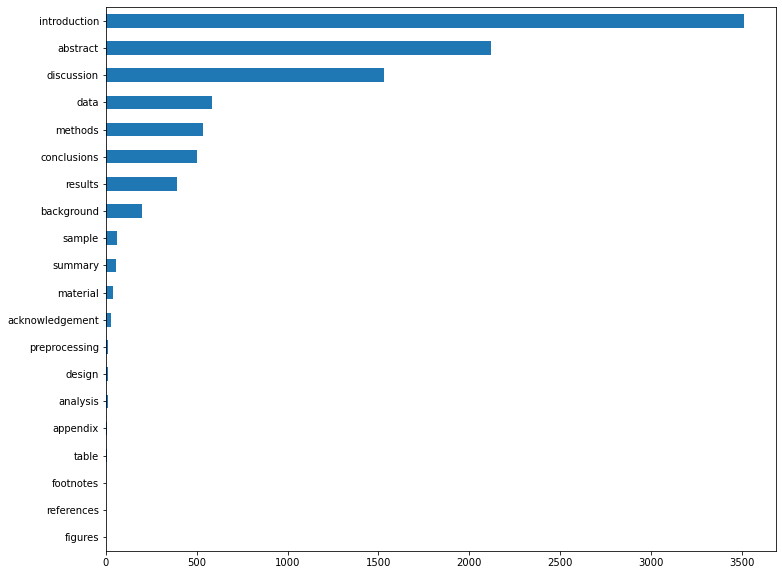

In [36]:
section_counts = df_normal['clean_section'].value_counts().sort_values()
section_counts.plot(kind='barh',figsize=(12,10))

## What **distinctive terms** accompany data citations?
Get scores for frequent and distinctive terms

In [ ]:
v = TfidfVectorizer(max_df=.5, min_df=1, stop_words='english', use_idf=True, norm=None)
x = v.fit_transform(df_normal['dataset_label']).toarray()

for counter, doc in enumerate(x):
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)

one_doc_as_df

## Are more data citations **formal or informal**?

Split all sections in "normal" publication sections into sentences; keep only those sentences that contain a reference to a dataset label. Splitting with `nltk.sent_tokenize` gives better results than by delimiter (.) 

**Note**: We may want to return to this if we need examples of sentences without data citations. Not saving df now as it's too large and can be reproduced

In [48]:
# sent = pd.DataFrame(df_normal.text.str.split('.').tolist(), index=df_normal.Id).stack()
sent = pd.DataFrame(df_normal['text'].apply(sent_tokenize).tolist(), index=df_normal.Id).stack()
sent = sent.reset_index()[[0, 'Id']]
sent.columns = ['sent', 'Id']

df_sent = sent.merge(df_normal, on='Id')
df_sent = df_sent.drop(columns=['clean_text', 
                      'clean_section', 
                      'match', 
                      'text', 
                      'cleaned_label'])

df_sent['dataset_label'] = df_sent['dataset_label'].astype(str)
df_sent['sent'] = df_sent['sent'].astype(str)
df_sent['match'] = df_sent.apply(lambda x: x.dataset_label in x.sent, axis=1)
df_sent['match'].value_counts()

False    652647
True      43003
Name: match, dtype: int64

Save dataframe of labeled sentences containing dataset references for training

In [49]:
df_sent = df_sent[df_sent['match']==True]
df_sent = df_sent.drop(columns=['match'])
df_sent = df_sent[['Id', 'pub_title', 'section_title', 'sent', 'dataset_title', 'dataset_label']]
df_sent.sample(n=5)
# df_sent.to_csv(path+'training_sentences.csv')

,Id,pub_title,section_title,sent,dataset_title,dataset_label
662250,70533ed6-4e37-43cb-989e-33abac373fb1,Estimating breeding bird survey trends and ann...,Introduction,The North American Breeding Bird Survey (BBS) ...,North American Breeding Bird Survey (BBS),North American Breeding Bird Survey
414639,445b14cf-2f37-4af3-9f92-bd653c37758e,Systematic comparison of different techniques ...,Discussion,The primary goal of ADNI has been to investiga...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI
441939,4847a4e1-7e35-4d9b-8165-57ca883c273c,Rate of Conversion from Prodromal Alzheimer's ...,Discussion,The studies of the ADNI cohort reported marked...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI
556499,ace6ee4a-051a-490f-9e5d-fd139a0fa8d6,The Relationship between Teachers’ Perceptions...,Introduction,This study used wave 1 data from the High Scho...,High School Longitudinal Study,High School Longitudinal Study
332514,1043c7c0-c4a9-4be8-99de-f6758fe5eadd,Surgery and Brain Atrophy in Cognitively Norma...,Discussion,‡ ‡ Data used in preparation of this article w...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI


Example of a **formal** data reference where dataset is cited like a publication using author names, year, url

In [58]:
df_sent.iloc[3000,3]

'(2009) , the authors applied statistical techniques to both ADNI and BLSA subjects (Shock et al., 1984) .'

In [60]:
df_sent.iloc[3000,2]

'Discussion'

Example of an **informal** data reference: mentions datasets by name/variant, possibly as a comparison

In [62]:
df_sent.iloc[680,3]

'In the original, unmodified SLOSH model, the magnitude of the radially variable factor used in the background wind (1) has a maximum value of 0.5 at R max , and decreases toward the core and outer radius of the storm.'

In [63]:
df_sent.iloc[680,2]

'Abstract'

## What **indicator terms** accompany a data citation?

Let's see if the sentences with data references include terms and phrases indicating data sharing and reuse as predicted by Park et al. (2018). We add:

[check for URL before cleaning]

- "nsf", "national science foundation", "grant" (these may be given in an acknowledgements section)
- "doi"

In [64]:
indicator_terms = ["accession", 
                   "available at", 
                   "available from", 
                   "com", 
                   "commercial", 
                   "corp", 
                   "dataset", 
                   "datasets", 
                   "database", 
                   "deposited",
                   "doi",
                   "donated",
                   "edu",
                   "ftp", 
                   "gift", 
                   "gov", 
                   "inc", 
                   "national institutes of health", 
                   "national science foundation",
                   "nih", 
                   "nsf",
                   "grant",
                   "obtained from", 
                   "publicly available", 
                   "purchased from", 
                   "repository", 
                   "sample sets stored", 
                   "suppl", 
                   "supplemental",
                   "survey"]

ind_pattern = '|'.join(indicator_terms)

def search_pat(search_str:str, search_list:str):
    search_obj = re.search(search_list, search_str)
    if search_obj:
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = 'NA'
    return return_str

df_sent['sent_clean'] = df_sent['sent'].apply(clean_text)
df_sent['indicator'] = df_sent['sent_clean'].apply(lambda x: search_pat(search_str=x, search_list=ind_pattern))
df_sent = df_sent[df_sent.indicator != 'NA']

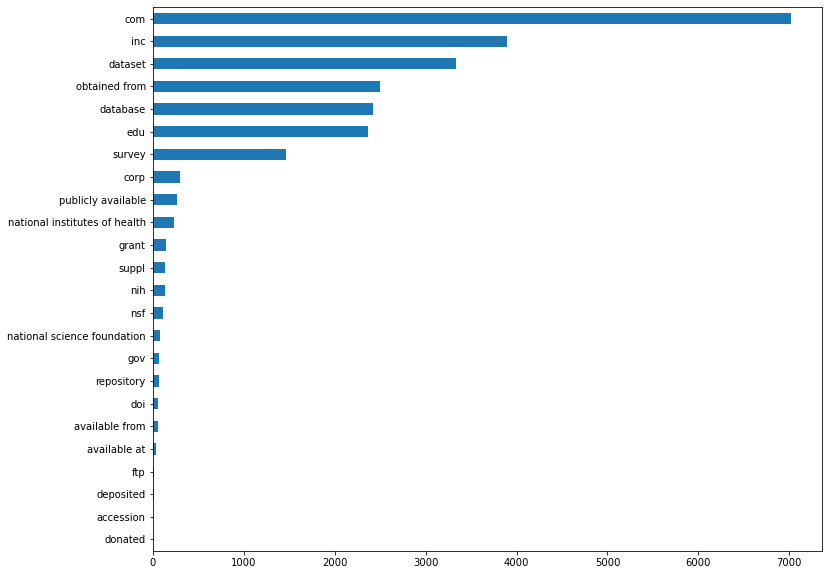

In [65]:
indicator_counts = df_sent['indicator'].value_counts().sort_values()
indicator_counts.plot(kind='barh',figsize=(12,10))

## What **named entities** are mentioned in data citations?

Full dataframe of citances is too large, so create a random 1% sample for demonstration of spaCy NER

In [131]:
sent_sample = df_sent.sample(1976)
citances = [x for x in sent_sample.sent]
print(citances[0])

CO-Search displays content from over 128,000 coronavirus-related scientific papers made available through the COVID-19 Open Research Dataset Challenge (CORD-19) [23] -an initiative put forth by the US White House and other prominent institutions in early 2020.


In [132]:
spacy.displacy.render(nlp(str(citances[0])), jupyter=True, style='ent')

In [133]:
doc = nlp(citances[0])
print([(X.text, X.label_) for X in doc.ents])

[('CO-Search', 'ORG'), ('over 128,000', 'CARDINAL'), ('23', 'CARDINAL'), ('US', 'GPE'), ('White House', 'ORG'), ('early 2020', 'DATE')]


Parsing: "B" means the token begins an entity, "I" means it is inside an entity, "O" means it is outside an entity, and "" means no entity tag is set

In [134]:
print([(X, X.ent_iob_, X.ent_type_) for X in doc])

[(CO, 'B', 'ORG'), (-, 'I', 'ORG'), (Search, 'I', 'ORG'), (displays, 'O', ''), (content, 'O', ''), (from, 'O', ''), (over, 'B', 'CARDINAL'), (128,000, 'I', 'CARDINAL'), (coronavirus, 'O', ''), (-, 'O', ''), (related, 'O', ''), (scientific, 'O', ''), (papers, 'O', ''), (made, 'O', ''), (available, 'O', ''), (through, 'O', ''), (the, 'O', ''), (COVID-19, 'O', ''), (Open, 'O', ''), (Research, 'O', ''), (Dataset, 'O', ''), (Challenge, 'O', ''), ((, 'O', ''), (CORD-19, 'O', ''), (), 'O', ''), ([, 'O', ''), (23, 'B', 'CARDINAL'), (], 'O', ''), (-an, 'O', ''), (initiative, 'O', ''), (put, 'O', ''), (forth, 'O', ''), (by, 'O', ''), (the, 'O', ''), (US, 'B', 'GPE'), (White, 'B', 'ORG'), (House, 'I', 'ORG'), (and, 'O', ''), (other, 'O', ''), (prominent, 'O', ''), (institutions, 'O', ''), (in, 'O', ''), (early, 'B', 'DATE'), (2020, 'I', 'DATE'), (., 'O', '')]


In [135]:
labels = [x.label_ for x in doc.ents]
len(labels)
Counter(labels)

Counter({'ORG': 2, 'CARDINAL': 2, 'GPE': 1, 'DATE': 1})

In [136]:
items = [x.text for x in doc.ents]
Counter(items).most_common(3)

[('CO-Search', 1), ('over 128,000', 1), ('23', 1)]

In [137]:
dict([(str(x), x.label_) for x in nlp(str(doc)).ents])

{'CO-Search': 'ORG',
 'over 128,000': 'CARDINAL',
 '23': 'CARDINAL',
 'US': 'GPE',
 'White House': 'ORG',
 'early 2020': 'DATE'}

Define functions for extracting named entities in dataframe

In [138]:
def extract_named_ents(text):
    """Extract named entities, and beginning, middle and end idx using spaCy's out-of-the-box model. 
    
    Keyword arguments:
    text -- the actual text source from which to extract entities
    
    """
#     return [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in nlp(text).ents]
    return [(ent.text, ent.label_) for ent in nlp(text).ents]

def add_named_ents(df):
    """Create new column in data frame with named entity tuple extracted.
    
    Keyword arguments:
    df -- a dataframe object
    
    """
    sent_sample['named_ents'] = sent_sample['sent'].apply(extract_named_ents)    

In [139]:
add_named_ents(sent_sample)
sent_sample

,Id,pub_title,section_title,sent,dataset_title,dataset_label,sent_clean,indicator,named_ents
681747,dfe9b4c7-dd54-487b-b062-7bfae3af3891,CO-Search: COVID-19 Information Retrieval with...,Discussion,"CO-Search displays content from over 128,000 c...",COVID-19 Open Research Dataset (CORD-19),COVID-19 Open Research Dataset,co search displays content from over 128 000 c...,dataset,"[(CO-Search, ORG), (over 128,000, CARDINAL), (..."
86842,d9cbcde9-b080-42c7-833d-2cad7fc1dc22,Educational Barriers of Rural Youth: Relation ...,Abstract,Information on additional characteristics of p...,Common Core of Data,NCES Common Core of Data,information on additional characteristics of p...,obtained from,[]
638944,7eb34da0-11f5-4e07-8b9c-9ffa4d11f2f1,Farm household income volatility: An analysis...,Conclusion,This study used a newly created panel dataset ...,Agricultural Resource Management Survey,Agricultural Resource Management Survey,this study used a newly created panel dataset ...,dataset,"[(the 1996 to, DATE), (Agricultural Resource M..."
342185,c8250c34-7e33-4330-bd1c-777c722be196,Enhancing Learnability of classification algor...,Abstract,"Here, Table 1 contains the major issues covere...",Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,here table 1 contains the major issues covered...,dataset,[]
126939,aaa61ab2-240c-4736-ad8b-cadc985033b1,Reproducible evaluation of classification meth...,Introduction,A large number of published works uses the pub...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,a large number of published works uses the pub...,publicly available,[]
...,...,...,...,...,...,...,...,...,...
142597,d3b80754-bf06-4f97-a590-5ec04f3965d2,Heterogeneity of neuroanatomical patterns in p...,Abstract,"Also, previous findings (Nettiksimmons et al.,...",Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,also previous findings nettiksimmons et al 201...,inc,"[(2014, DATE), (11, CARDINAL)]"
508748,1312e8fa-f7f0-485b-89e3-933919e6194d,Volumetric comparison of hippocampal subfields...,Abstract,A recent study compared the accelerated and no...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,a recent study compared the accelerated and no...,com,[]
380690,a0ec03e0-cd63-4684-b3d7-b1cf6f74948f,r Human Brain Mapping 00:000–000 (2012) r Pred...,Abstract,"V C 2012 Wiley Periodicals, Inc.\nKey words: A...",Alzheimer's Disease Neuroimaging Initiative (A...,Alzheimer's Disease Neuroimaging Initiative (A...,v c 2012 wiley periodicals inc key words alzhe...,inc,"[(MCI, ORG), (SVM, ORG)]"
210914,d95df0c0-456c-479f-9a64-e32e1c9f1a26,Linking Genetics of Brain Changes to Alzheimer...,Data,A complete listing of ADNI investigators can b...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,a complete listing of adni investigators can b...,com,[]


Most common tokens appearing across randomly sampled citances

In [140]:
tokens = nlp(''.join(str(sent_sample.sent.tolist())))
items = [x.label_  for x in tokens.ents]
Counter(items).most_common(20)

[('ORG', 2412),
 ('CARDINAL', 1494),
 ('DATE', 750),
 ('PERSON', 320),
 ('GPE', 291),
 ('ORDINAL', 130),
 ('NORP', 100),
 ('WORK_OF_ART', 66),
 ('PERCENT', 66),
 ('PRODUCT', 48),
 ('LOC', 45),
 ('EVENT', 29),
 ('LAW', 28),
 ('MONEY', 16),
 ('FAC', 13),
 ('TIME', 13),
 ('QUANTITY', 11)]

## What are the **research fields** of publications and datasets?
TBD: Use "Field of Research (FoR) Codes categorize research activity according to the field in which research is undertaken and based on the processes and techniques used in the R&D" [(Source)](https://www.newcastle.edu.au/research/support/services/grants-and-funding/forms-and-codes/for-codes)

In [ ]:
fields = ["Mathematical Sciences", "Physical Sciences", "Chemical Sciences", "Earth Sciences", "Environmental Sciences", 
          "Biological Sciences", "Agricultural and Veterinary Sciences", "Information and Computing Sciences", "Engineering", 
          "Technology", "Medical and Health Sciences", "Built Environment and Design", "Education", "Economics", 
          "Commerce, Management, Tourism and Services", "Studies in Human Society", "Psychology and Cognitive Sciences",
          "Law and Legal Studies", "Studies in Creative Arts and Writing", "Language, Communication and Culture",
          "History and Archaeology", "Philosophy and Religious Studies"]